In [2]:
import numpy as np
import os, sys

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import zarr

from utils import remove_all_ticks_and_labels
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

# evaluating at mean vs current sample
checking the effect of evaluating the likelihood function at the mean of the prior transition operator $\mu_\theta$ vs at the current sample $\mathbf{x}_t$

In [2]:
from utils import select_model
prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 47)
from dataset_utils import generate_2d_swiss_roll

v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
likelihood_sigma = 0.1
s = 0.1

from likelihood_utils import posterior_sample_loop_occlusion, sequential_posterior_sampler
# sample_size = int(5e2)
sample_size = int(1e3)

# iid samples from the posterior that uses the continuous likelihood
print('DM')
samples_iid_reverse_xt = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, eval_at_mean=False)
samples_iid_reverse_mu = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, eval_at_mean=True)

# sequential samples from the posterior that uses the continuous likelihood
print('neural sampling')
num_samples_in_gt_manifold = int(1e3)
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]
manifold_initial_point = dataset[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
z_seq_xt, samples_seq_reverse_xt = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles=sample_size, eval_at_mean=False)
z_seq_mu, samples_seq_reverse_mu = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles=sample_size, eval_at_mean=True)

model loaded!
DM


KeyboardInterrupt: 

iid samples

[Text(0, 0.5, 'eval at sample $\\mu_\\theta$')]

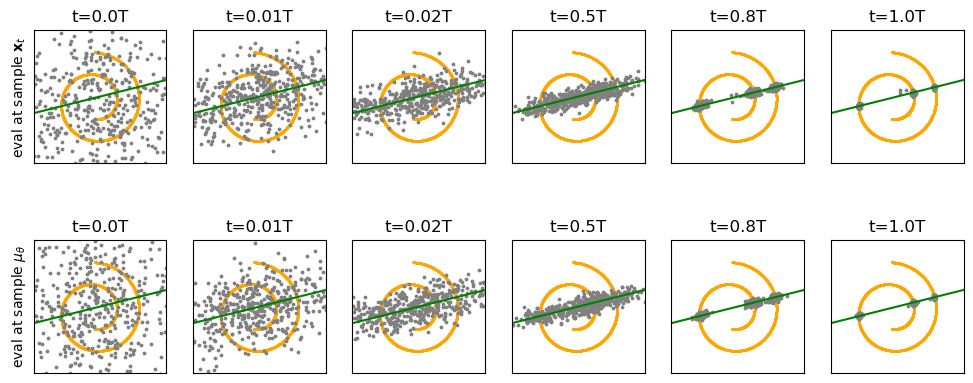

In [ ]:
from plot import draw_constraint_line
# plot the distributions
temps = [0, 1, 2, 50, 80, 100]
lim=1.5
lims = [-lim, lim]

# plot the reverse process of the iid generated posterior samples at different temperatures
fig, ax = plt.subplots(2, len(temps), figsize=(12, 5), sharex=True, sharey=True)
idx = 0
for i, temp in enumerate(temps):
    for j in range(2):
        if j == 0:
            ax[j, i].scatter(*dataset.T, s=1, c='orange')
            ax[j, i].scatter(*samples_iid_reverse_xt[int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
            draw_constraint_line(ax[j, i], v, likelihood_sigma, lim, show_stdev=False)
            ax[j, i].set(title=f't={int(temp)/100}T')
            ax[j, i].set(xlim=lims, ylim=lims, aspect='equal')
            remove_all_ticks_and_labels(ax[j, i])
        if j == 1:
            ax[j, i].scatter(*dataset.T, s=1, c='orange')
            ax[j, i].scatter(*samples_iid_reverse_mu[int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
            draw_constraint_line(ax[j, i], v, likelihood_sigma, lim, show_stdev=False)
            ax[j, i].set(title=f't={int(temp)/100}T')
            ax[j, i].set(xlim=lims, ylim=lims, aspect='equal')
            remove_all_ticks_and_labels(ax[j, i])
ax[0, 0].set(ylabel='eval at sample $\mathbf{x}_t$')
ax[1, 0].set(ylabel='eval at sample $\mu_\\theta$')

neural sampling

[Text(0, 0.5, 'eval at sample $\\mu_\\theta$')]

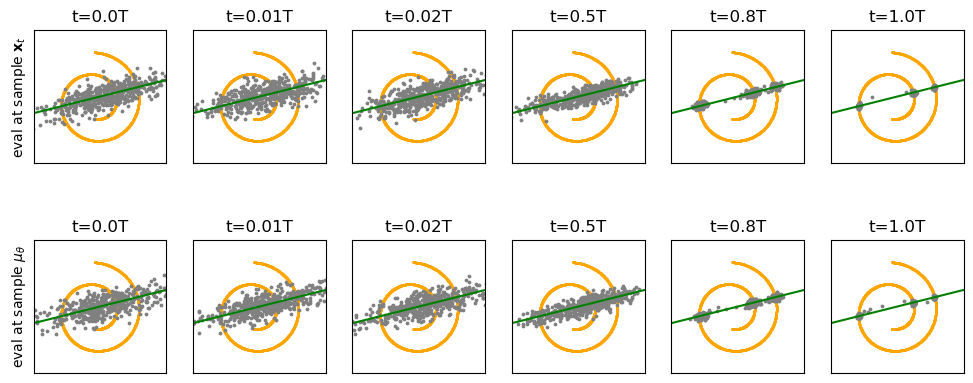

In [ ]:
from plot import draw_constraint_line
# plot the distributions
temps = [0, 1, 2, 50, 80, 100]
lim=1.5
lims = [-lim, lim]

# plot the reverse process of the iid generated posterior samples at different temperatures
fig, ax = plt.subplots(2, len(temps), figsize=(12, 5), sharex=True, sharey=True)
idx = 0
for i, temp in enumerate(temps):
    for j in range(2):
        if j == 0:
            ax[j, i].scatter(*dataset.T, s=1, c='orange')
            ax[j, i].scatter(*samples_seq_reverse_xt[:, int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
            draw_constraint_line(ax[j, i], v, likelihood_sigma, lim, show_stdev=False)
            ax[j, i].set(title=f't={int(temp)/100}T')
            ax[j, i].set(xlim=lims, ylim=lims, aspect='equal')
            remove_all_ticks_and_labels(ax[j, i])
        if j == 1:
            ax[j, i].scatter(*dataset.T, s=1, c='orange')
            ax[j, i].scatter(*samples_seq_reverse_mu[:, int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
            draw_constraint_line(ax[j, i], v, likelihood_sigma, lim, show_stdev=False)
            ax[j, i].set(title=f't={int(temp)/100}T')
            ax[j, i].set(xlim=lims, ylim=lims, aspect='equal')
            remove_all_ticks_and_labels(ax[j, i])
ax[0, 0].set(ylabel='eval at sample $\mathbf{x}_t$')
ax[1, 0].set(ylabel='eval at sample $\mu_\\theta$')

now calculate the KL divergence between the iid and sequential samples

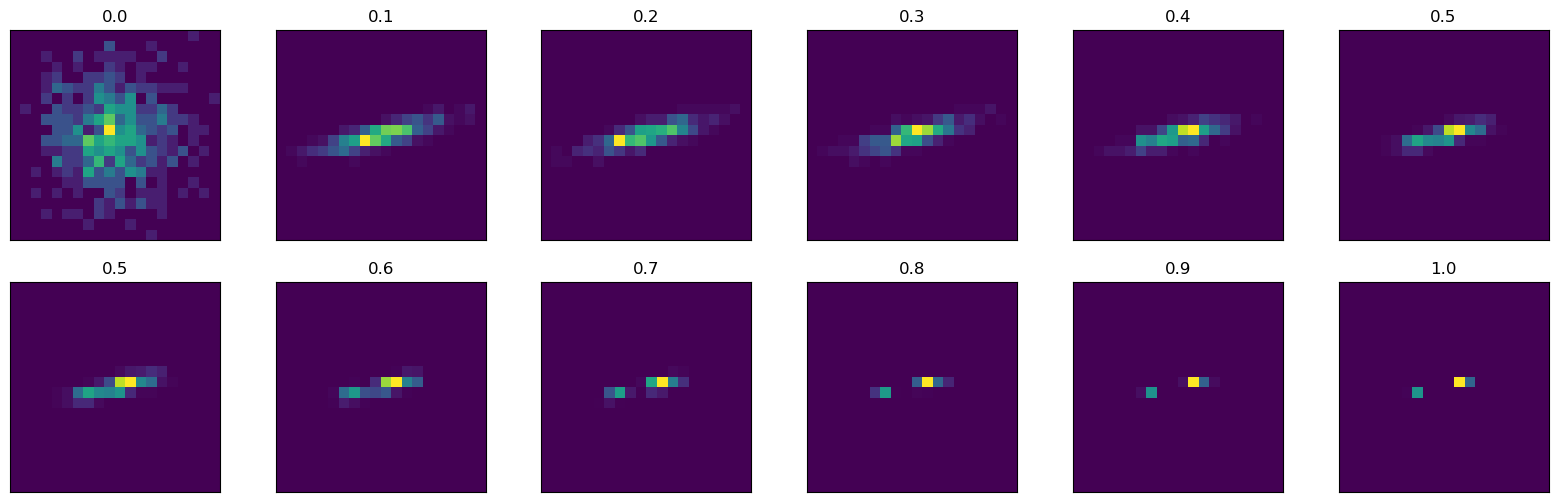

In [ ]:
# now calculate the histogram of samples from the amortized posterior for all thetas
from likelihood_utils import calculate_histogram_for_seq_data, calculate_histogram_for_iid_data

# iid
histograms_iid_xt = calculate_histogram_for_iid_data(samples_iid_reverse_xt, num_bins=20, lim=3)
histograms_iid_mu = calculate_histogram_for_iid_data(samples_iid_reverse_mu, num_bins=20, lim=3)

# sequential
histograms_seq_xt = calculate_histogram_for_seq_data(samples_seq_reverse_xt, num_bins=20, lim=3)
histograms_seq_mu = calculate_histogram_for_seq_data(samples_seq_reverse_mu, num_bins=20, lim=3)



histograms = histograms_iid_mu

# plot for xt
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
idx0 = 0
idx1 = 0
for h, hist in enumerate(histograms):
    if h in [0, 10, 20, 30, 40, 50]:
        a = ax[0, idx0]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx0 += 1
    if h in [50, 60, 70, 80, 90, 100]:
        a = ax[1, idx1]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx1 += 1

now we can calculate the KL divergence between the xt and mu based samples

In [ ]:
from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

# ------------------------------------ iid ----------------------------------- #
p = histograms_iid_mu + epsilon  # xt distribution
q = histograms_iid_xt + epsilon  # mu distribution

entropies_iid = []
for phi in range(len(histograms_iid_mu)):
    p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
    q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
    entropies_iid.append(entropy(p_phi, q_phi))
entropies_iid = np.stack(entropies_iid)


# -------------------------------- sequential -------------------------------- #
p = histograms_seq_mu + epsilon  # xt distribution

q = histograms_seq_xt + epsilon  # mu distribution

entropies_seq = []
for phi in range(len(histograms_seq_mu)):
    p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
    q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
    entropies_seq.append(entropy(p_phi, q_phi))
entropies_seq = np.stack(entropies_seq)

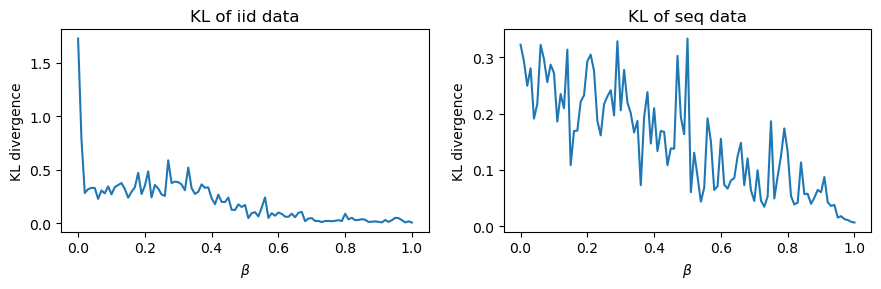

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ls = np.linspace(0, 1, len(entropies_seq))
ax[0].plot(ls, entropies_iid)
ax[0].set(title='KL of iid data', ylabel='KL divergence', xlabel='$\\beta$')
# ax[0].set(yticks=[0, 0.5, 1, 1.5, 2])

ax[1].plot(ls, entropies_seq)
ax[1].set(title='KL of seq data', ylabel='KL divergence', xlabel='$\\beta$')

fig.tight_layout()

## average of many runs
now run this 100 times to get the mean and std of the KL divergence 

In [ ]:
from utils import select_model
prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 47)
from dataset_utils import generate_2d_swiss_roll

v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
likelihood_sigma = 0.1
s = 0.1

from likelihood_utils import posterior_sample_loop_occlusion, sequential_posterior_sampler
# sample_size = int(5e2)
sample_size = int(1e3)
num_samples_in_gt_manifold = int(1e3)
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]

num_runs = 100

In [ ]:
# --------------------------- iid samples using xt --------------------------- #
samples_iid_reverse_xts = []

for i in range(num_runs):
    # iid samples from the posterior that uses the continuous likelihood
    samples_iid_reverse_xt = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, eval_at_mean=False, device=device)
    samples_iid_reverse_xts.append(samples_iid_reverse_xt)
samples_iid_reverse_xts = np.stack(samples_iid_reverse_xts)

import zarr
zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc/sample_size=1e3', 'iid_xts.zarr'), samples_iid_reverse_xts)

model loaded!
Using device: cuda


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [ ]:
# --------------------------- iid samples using mus -------------------------- #
samples_iid_reverse_mus = []

for i in range(num_runs):
    # iid samples from the posterior that uses the continuous likelihood
    samples_iid_reverse_mu = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, eval_at_mean=True, device=device)
    samples_iid_reverse_mus.append(samples_iid_reverse_mu)
samples_iid_reverse_mus = np.stack(samples_iid_reverse_mus)

import zarr
zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc/sample_size=1e3', 'iid_mus.zarr'), samples_iid_reverse_mus)


In [ ]:
# ------------------------- neural sampling using xts ------------------------ #
samples_seq_reverse_xts = []

for i in range(num_runs):
    # sequential samples from the posterior that uses the continuous likelihood
    manifold_initial_point = dataset[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
    
    samples_seq_reverse_xt = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles=sample_size, eval_at_mean=False, device=device)[1]
    samples_seq_reverse_xts.append(samples_seq_reverse_xt)
samples_seq_reverse_xts = np.stack(samples_seq_reverse_xts)

import zarr
zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc/sample_size=1e3', 'seq_xts.zarr'), samples_seq_reverse_xts)

In [ ]:
# ------------------------- neural sampling using mus ------------------------ #
samples_seq_reverse_mus = []

for i in range(num_runs):
    # sequential samples from the posterior that uses the continuous likelihood
    manifold_initial_point = dataset[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
    
    samples_seq_reverse_mu = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles=sample_size, eval_at_mean=True, device=device)[1]
    samples_seq_reverse_mus.append(samples_seq_reverse_mu)
samples_seq_reverse_mus = np.stack(samples_seq_reverse_mus)

import zarr
zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc/sample_size=1e3', 'seq_mus.zarr'), samples_seq_reverse_mus)

## histograms -> KL
now construct histograms of the samples and calculate the KL

In [3]:
samples_iid_reverse_xts = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc/sample_size=1e3_runs=200', 'iid_xts.zarr'))
samples_iid_reverse_mus = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc/sample_size=1e3_runs=200', 'iid_mus.zarr'))
samples_seq_reverse_xts = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc/sample_size=1e3_runs=200', 'seq_xts.zarr'))
samples_seq_reverse_mus = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc/sample_size=1e3_runs=200', 'seq_mus.zarr'))
num_runs = 200

In [6]:
# now calculate the histogram of samples from the amortized posterior for all thetas
from likelihood_utils import calculate_histogram_for_seq_data, calculate_histogram_for_iid_data

num_bins_per_dim = 15
domain_range = 3

histograms_iid_xts = []
histograms_iid_mus = []
histograms_seq_xts = []
histograms_seq_mus = []

for i in range(num_runs):
    # iid
    histograms_iid_xt = calculate_histogram_for_iid_data(samples_iid_reverse_xts[i], num_bins_per_dim, domain_range)
    histograms_iid_mu = calculate_histogram_for_iid_data(samples_iid_reverse_mus[i], num_bins_per_dim, domain_range)

    # sequential
    histograms_seq_xt = calculate_histogram_for_seq_data(samples_seq_reverse_xts[i], num_bins_per_dim, domain_range)
    histograms_seq_mu = calculate_histogram_for_seq_data(samples_seq_reverse_mus[i], num_bins_per_dim, domain_range)

    histograms_iid_xts.append(histograms_iid_xt)
    histograms_iid_mus.append(histograms_iid_mu)
    histograms_seq_xts.append(histograms_seq_xt)
    histograms_seq_mus.append(histograms_seq_mu)

histograms_iid_xts = np.stack(histograms_iid_xts)
histograms_iid_mus = np.stack(histograms_iid_mus)
histograms_seq_xts = np.stack(histograms_seq_xts)
histograms_seq_mus = np.stack(histograms_seq_mus) 
print(histograms_iid_xts.shape)


from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

entropies_iids = []
entropies_seqs = []

for i in range(num_runs):
    # ------------------------------------ iid ----------------------------------- #
    p = histograms_iid_mus[i] + epsilon  # xt distribution
    q = histograms_iid_xts[i] + epsilon  # mu distribution

    entropies_iid = []
    for phi in range(len(histograms_iid_mus[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_iid.append(entropy(p_phi, q_phi))
    entropies_iid = np.stack(entropies_iid)
    entropies_iids.append(entropies_iid)


    # -------------------------------- sequential -------------------------------- #
    p = histograms_seq_mus[i] + epsilon  # xt distribution
    q = histograms_seq_xts[i] + epsilon  # mu distribution

    entropies_seq = []
    for phi in range(len(histograms_seq_mus[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_seq.append(entropy(p_phi, q_phi))
    entropies_seq = np.stack(entropies_seq)
    entropies_seqs.append(entropies_seq)

entropies_iids = np.stack(entropies_iids)
entropies_seqs = np.stack(entropies_seqs)
print(entropies_iids.shape)

(200, 101, 15, 15)
(200, 101)


## plot

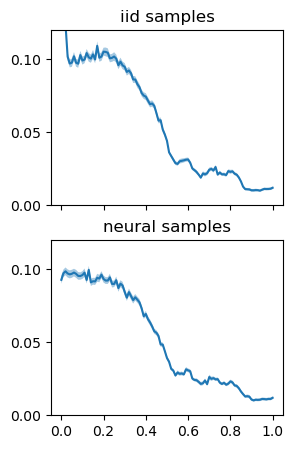

In [19]:
mean_entropy_iid = np.mean(entropies_iids, axis=0)
mean_entropy_seq = np.mean(entropies_seqs, axis=0)
std_entropy_iid = np.std(entropies_iids, axis=0) /  np.sqrt(num_runs)
std_entropy_seq = np.std(entropies_seqs, axis=0) / np.sqrt(num_runs)

fig, ax = plt.subplots(2, 1, figsize=(3, 5), sharex=True)
ls = np.linspace(0, 1, len(mean_entropy_seq))
ax[0].plot(ls, mean_entropy_iid)
ax[0].fill_between(ls, mean_entropy_iid-std_entropy_iid, mean_entropy_iid+std_entropy_iid, alpha=0.4)
ax[0].set(title='iid samples')
# ax[0].set(ylim=[0, 0.2])

ax[1].plot(ls, mean_entropy_seq)
ax[1].fill_between(ls, mean_entropy_seq-std_entropy_seq, mean_entropy_seq+std_entropy_seq, alpha=0.4)
# ax[1].set(title='neural samples', ylabel='KL divergence', xlabel='$\\beta_t$')
ax[1].set(title='neural samples')
# ax[1].set(ylim=[0, 0.2])

for a in ax:
    a.set(ylim=[0, 0.12], yticks=[0, 0.05, 0.1], xticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

from plot import save_fig
save_fig(fig, 'figure2-evaluation-location')

In [ ]:
# save data
import zarr
# zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'iid_xts.zarr'), histograms_iid_xts)
# zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'iid_mus.zarr'), histograms_iid_mus)
# zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'seq_xts.zarr'), histograms_seq_xts)
# zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'seq_mus.zarr'), histograms_seq_mus)
histograms_iid_xts = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'iid_xts.zarr'))
histograms_iid_mus = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'iid_mus.zarr'))
histograms_seq_xts = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'seq_xts.zarr'))
histograms_seq_mus = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'seq_mus.zarr'))